# Discovering the KdV equation from data

In [11]:
import pysindy as ps

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat


## Importing the Dataset

In [12]:
KdV_data = loadmat('./kdv_data.mat')

In [13]:
u = KdV_data['u']
x = KdV_data['x'].flatten()
t = KdV_data['t'].flatten()
dt = t[1] - t[0]
dx = x[1] - x[0]

Checking the shape of the data

In [14]:
print(' Number of time points:', t.shape, '\n Number of spatial points:', x.shape, '\n Shape of the u:', u.shape)

 Number of time points: (51,) 
 Number of spatial points: (401,) 
 Shape of the u: (51, 401)


Therefore, the data imported has the shape u(T,X), with T being time, and X being space.
You should also check that the time and space are indeed sampled at fixed frequency (open `t` and `x` to check!)

## Visualise

It is always a good idea to have a sanity check that the data make sense and see if there are potential challenges.

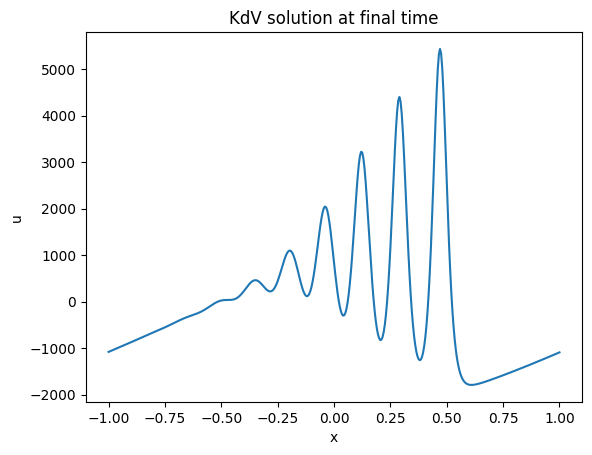

In [15]:
plt.plot(x,u[-1,:])
plt.xlabel('x')
plt.ylabel('u')
plt.title('KdV solution at final time')
plt.show()

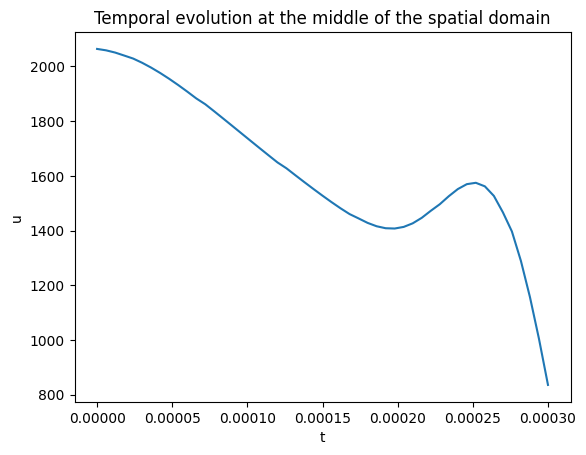

In [16]:
plt.plot(t,u[:,200])
plt.xlabel('t')
plt.ylabel('u')
plt.title('Temporal evolution at the middle of the spatial domain')
plt.show()

Text(0.5, 1.0, '$u(x, t)$')

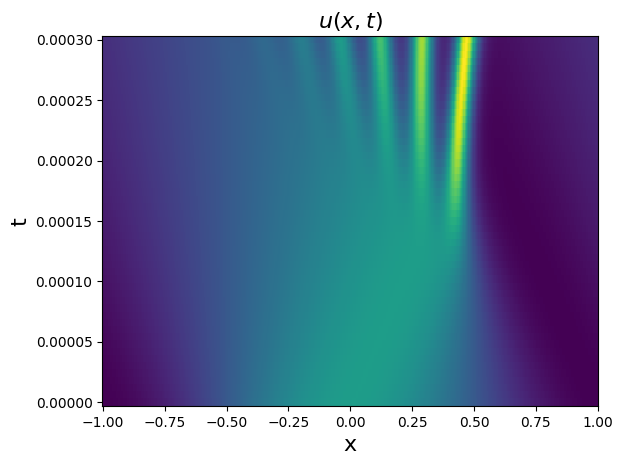

In [17]:
# Plot derivative results
plt.figure()
plt.pcolormesh(x, t, u)
plt.xlabel('x', fontsize=16)
plt.ylabel('t', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)


Things to look out for:
- What is the scale of time `t`, `x`, and `u`?
    - That gives you a sense of the expected scale of the derivatives. 
    - Do you need to rescale things to make the learning easier?
- What's the signal time scale and length scale? 
    - Am I sampling frequently enough (e.g. above Nyquist frequency)?
- If the signal is noisy, can you at least make out the lengthscale and time scale? That will help you choose the right derivative scheme. For example, if it's too noisy but frequently sampled, may be you want to use weak formulation to filter the frequency signal.

## Generating the derivatives

In [18]:
# Time and space derivatives
ut = ps.FiniteDifference(d=1, axis=0)._differentiate(u, dt)
ux = ps.FiniteDifference(d=1, axis=1)._differentiate(u, dx)
uxx = ps.FiniteDifference(d=2, axis=1)._differentiate(u, dx)
uxxx = ps.FiniteDifference(d=3, axis=1)._differentiate(u, dx)
uxxxx = ps.FiniteDifference(d=4, axis=1)._differentiate(u, dx)

# We can also user other differentiation methods, e.g., smoothed finite difference, which first smooths the data with a Savitzky-Golay filter
# and then applies finite difference
ut_smooth = ps.SmoothedFiniteDifference(d=1, axis=0, smoother_kws={'window_length': 3,'polyorder': 1})._differentiate(u, t)



Again, it's always a good idea to check to make sure the derivatives are well approximated.

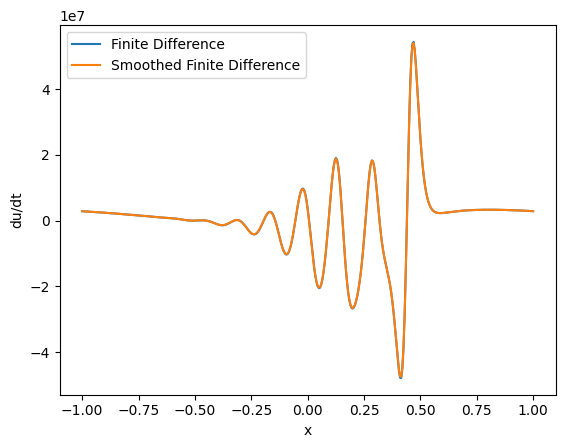

In [19]:
plt.plot(x,ut[40,:])
plt.plot(x,ut_smooth[40,:])
plt.xlabel('x')
plt.ylabel('du/dt') 
plt.legend(['Finite Difference','Smoothed Finite Difference'])

A good agreement between different derivative methods usually imply the approximation is good.
- If the agreement is not good, you may need to rethink about how the data is collected, or consider using other approximation method, such as weak formulation.

## Invoke PySINDy to learn

In [ ]:
# Define the library
#   Here we use the standard PDE library, which computes the derivatives automatically (using finite difference by default)
pde_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False), 
    derivative_order=3, # up to third order spatial derivatives
    spatial_grid=x
)
# Alternatively, we can also use weak formulation to compute the derivatives, which is more robust to noise
# X, T = np.meshgrid(x, t)
# XT = np.asarray([X, T]).T
# pde_lib = ps.WeakPDELibrary(
#     function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
#     derivative_order=3,
#     spatiotemporal_grid=XT,
# )

# Define the optimizer 
#   Think about why is the threshold so large? 
#   What is the order of magnitude of ut compared to normalised u.ux or uxxx?)
#   What does "normalize_columns=True" do?
optimizer = ps.STLSQ(threshold=1e9, normalize_columns=True)

# Define the SINDy model
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)

# Reshape the data and fit the model
#   Note that we need to transpose u and reshape u to have the shape (T, X, D)
#   Here D is the number of dimensions of the target, which is 1 in this case.
model_data = u.T.reshape(u.shape[1],u.shape[0],1)

# Call the regression algorithm
model.fit(model_data, t=dt, feature_names=['u'])
# If you want to use smoothed finite difference to compute ut, use `x_dot` argument to pass in the precomputed du/dt
# model.fit(model_data, t=dt, x_dot = ut_smooth.T.reshape(ut.shape[1],ut.shape[0],1), feature_names=['u'])

# print identified PDE
print("Identified PDE: ")
model.print()

Identified PDE: 
(u)' = -1.017 u_111 + -0.995 uu_1


Try to play around with different 
- PDE library, 
- deriviative method, 
- precomputed du/dt, 
- normalization and 
- threshold parameter.

Which combo of hyperparameters give you better/worse result? Why?


# When derivatives are hard to get

So far, the data provided are sampled frequently and nicely. What if the data is not sampled frequently enough?

## Import some more difficult dataset

In [23]:
KdV_data_difficult = loadmat('./kdv_data_for_workshop.mat')

In [24]:
u_difficult = KdV_data_difficult['u_only_mat_reshaped']
x_difficult = KdV_data_difficult['x_vec'].flatten()
t_difficult  = KdV_data_difficult['t_vec'].flatten()*5
dt_difficult = t_difficult[1] - t_difficult[0]
dx_difficult = x_difficult[1] - x_difficult[0]

In [25]:
print(' Number of time points:', t_difficult.shape, '\n Number of spatial points:', x_difficult.shape, '\n Shape of the u:', u_difficult.shape)

 Number of time points: (10,) 
 Number of spatial points: (400,) 
 Shape of the u: (8, 10, 400)


Note that this dataset is shaped differently. There are also 8 different datasets from the same equation.

## Visualise

Again, let's first visualise to see what problem this dataset may have.

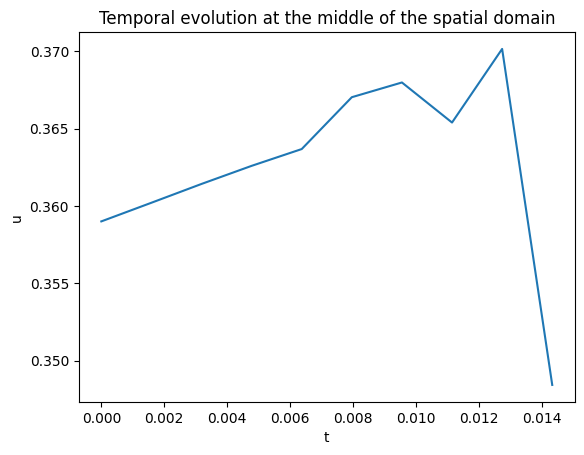

In [28]:
plt.plot(t_difficult,u_difficult[0,:,200])
plt.xlabel('t')
plt.ylabel('u')
plt.title('Temporal evolution at the middle of the spatial domain')
plt.show()

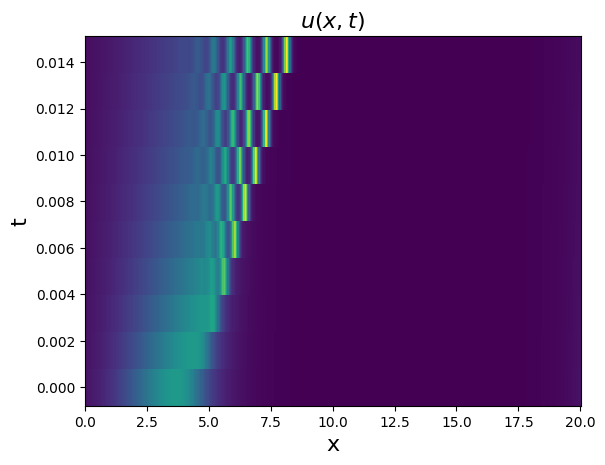

In [35]:
# Plot derivative results
plt.figure()
plt.pcolormesh(x_difficult, t_difficult, u_difficult[0,:,:])
plt.xlabel('x', fontsize=16)
plt.ylabel('t', fontsize=16)
plt.title(r'$u(x, t)$', fontsize=16)
plt.show()

The discrete jump in time suggests that approximating time derivatives will likely be a challenge!

Let's check that in more detail.

In [29]:
# Time and space derivatives
ut_difficult = ps.FiniteDifference(d=1, axis=1)._differentiate(u_difficult, dt_difficult)

# We can also user other differentiation methods, e.g., smoothed finite difference, which first smooths the data with a Savitzky-Golay filter
# and then applies finite difference
ut_smooth_difficult = ps.SmoothedFiniteDifference(d=1, axis=1, smoother_kws={'window_length': 3,'polyorder': 1})._differentiate(u_difficult, t_difficult)

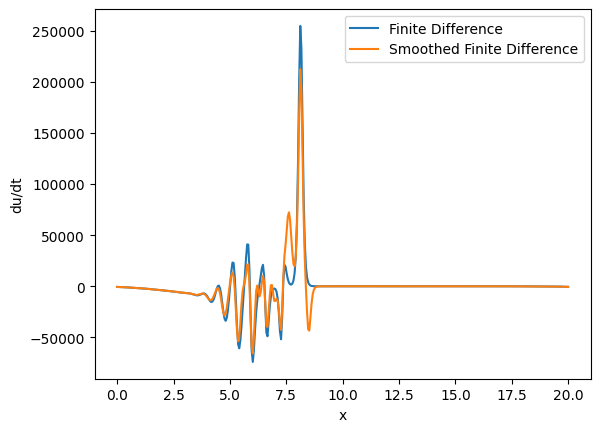

In [36]:
plt.plot(x_difficult,ut_difficult[0,8,:])
plt.plot(x_difficult,ut_smooth_difficult[0,8,:])
plt.xlabel('x')
plt.ylabel('du/dt') 
plt.legend(['Finite Difference','Smoothed Finite Difference'])
plt.show()

Indeed, finding good time derivative approximation is going to be a challenge!

Let's see how it impact learning.

In [66]:
# Define the library
# Here we use the standard PDE library, which computes the derivatives automatically (using finite difference by default)
pde_lib = ps.PDELibrary(
    function_library=ps.PolynomialLibrary(degree=2,include_bias=False), 
    derivative_order=3, # up to third order spatial derivatives
    spatial_grid=x_difficult
)
# Alternatively, we can also use weak formulation to compute the derivatives, which is more robust to noise
# X, T = np.meshgrid(x_difficult, t_difficult)
# XT = np.asarray([X, T]).T
# pde_lib = ps.WeakPDELibrary(
#     function_library=ps.PolynomialLibrary(degree=2,include_bias=False),
#     derivative_order=3,
#     spatiotemporal_grid=XT,
# )

# Define the optimizer 
#   Think about why is the threshold so large? 
#   What is the order of magnitude of ut compared to normalised u.ux or uxxx?)
#   What does "normalize_columns=True" do?
optimizer = ps.STLSQ(threshold=1e6, alpha=1e-4,normalize_columns=True)

# Define the SINDy model
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)

# Reshape the data and fit the model
#   Note that we need to transpose u and reshape u to have the shape (T, X, D)
#   Here D is the number of dimensions of the target, which is 1 in this case.
model_data = u_difficult[7,:,:]
model_data = model_data.T.reshape(model_data.shape[1],model_data.shape[0],1)

# Call the regression algorithm
model.fit(model_data, t=dt_difficult, feature_names=['u'])
# If you want to use smoothed finite difference to compute ut, use `x_dot` argument to pass in the precomputed du/dt
# model.fit(model_data, t=dt, x_dot = ut_smooth.T.reshape(ut.shape[1],ut.shape[0],1), feature_names=['u'])

# print identified PDE
print("Identified PDE: ")
model.print()

Identified PDE: 
(u)' = -23.875 u_11 + -3.858 u_111 + -1.471 uu_1 + 0.004 u^2u_1 + 0.125 uu_11 + 0.015 uu_111


Can you improve the result?